In [1]:
%run functions.ipynb
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## Example ROC curves

In [2]:
from sklearn.datasets import load_breast_cancer

In [3]:
X,y = load_breast_cancer(True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.94)

In [5]:
clf = LogisticRegression(C=0.9)
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.0

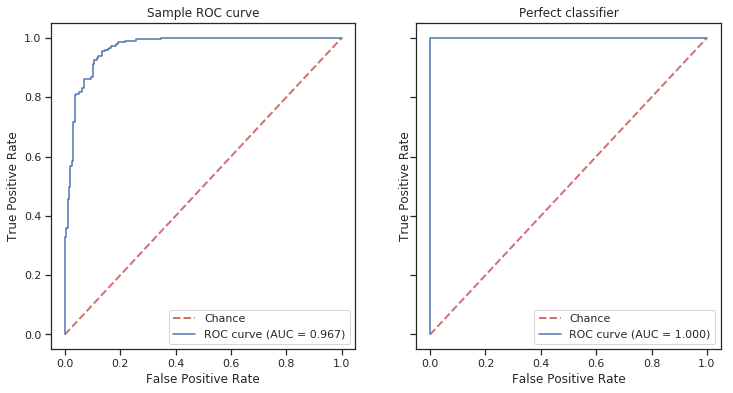

In [6]:
fig, (ax1, ax2) = subplots(nrows=1, ncols=2, sharey=True, figsize=(12,6))

plot_roc_curve(ax1, clf, X_test, y_test, 'Sample ROC curve')

labels = 50*[1] + 50*[0]
probs = 50*[0.9] + 50*[0.1]
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)
plot_roc(ax2, fpr, tpr, roc_auc, 'Perfect classifier')

## ROC curves for validation

In [7]:
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print(
    "(1, 0) labels count in train test: {} {}".format(
        (np.count_nonzero(y_train == 1), np.count_nonzero(y_train == 0)),
        (np.count_nonzero(y_test == 1), np.count_nonzero(y_test == 0)),
    )
)

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


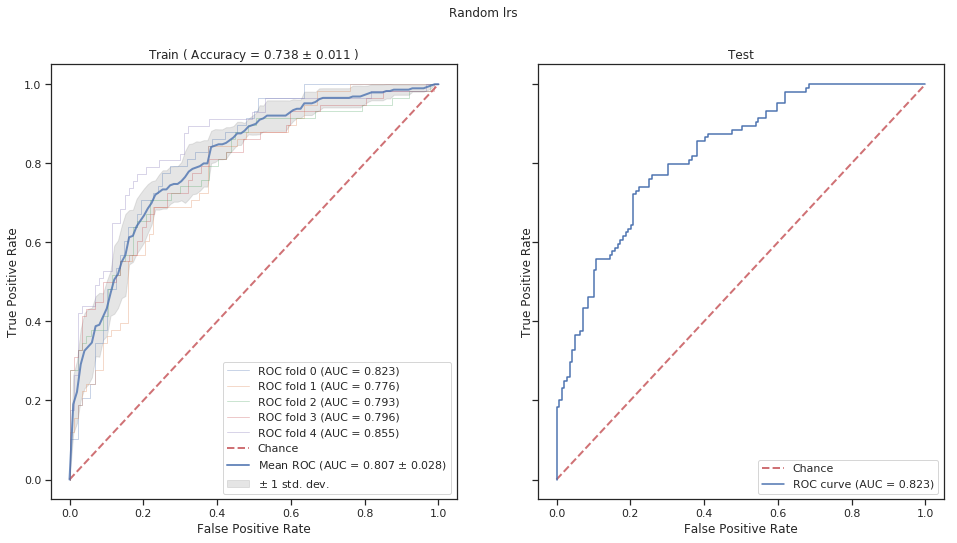

In [8]:
clf_random_lrs = fit_clf_with_cross_val(RandomLogisticsRegressions(n_estimators=21, penalty='l1', C=0.3, n_variables=2000), X_train, y_train, X_test, y_test, title='Random lrs')

## PCA and SPCA interpretation

In [9]:
standarizer = StandardScaler().fit(X_train)
X_std_train = standarizer.transform(X_train)
X_std_test = standarizer.transform(X_test)
singular = PCA().fit(X_std_train).singular_values_

726


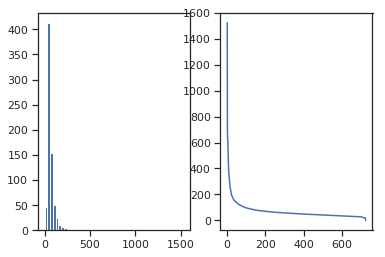

In [10]:
eigen = singular
print(len(eigen))
plt.figure()
plt.subplot(121)
plt.hist(eigen, bins=50)
plt.subplot(122)
plt.plot(np.arange(len(eigen)), eigen)
plt.show()

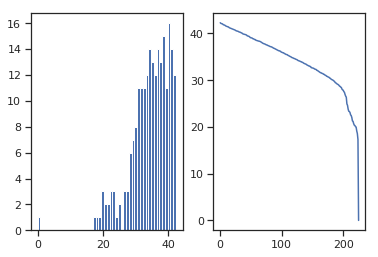

In [11]:
ind = 500
trunc_eigen = eigen[ind:]
plt.figure()
plt.subplot(121)
plt.hist(trunc_eigen, bins=50)
plt.subplot(122)
plt.plot(np.arange(len(trunc_eigen)), trunc_eigen)
plt.show()

In [12]:
spca = SPCWrapper(max_iter=100, n_components=1000, threshold_val=0.1).fit(X_std_train)
loadings = spca.V

In [13]:
print(loadings.shape)

(726, 12179)


0.9204584190327161


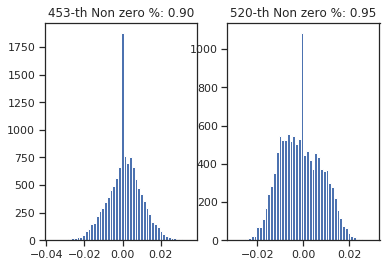

In [14]:
print(np.count_nonzero(loadings) / (X_train.shape[0]*X_train.shape[1]))

ind1 = np.random.randint(0, X_train.shape[0])
ind2 = np.random.randint(0, X_train.shape[0])

plt.figure()
plt.subplot(121)
plt.hist(loadings[ind1, :], bins=50)
plt.title('{}-th Non zero %: {:.2f}'.format(ind1, np.count_nonzero(loadings[ind1,:])/X_train.shape[1]))

plt.subplot(122)
plt.hist(loadings[ind2, :], bins=50)
plt.title('{}-th Non zero %: {:.2f}'.format(ind2, np.count_nonzero(loadings[ind2,:])/X_train.shape[1]))
plt.show()

## Feature selection based on SAM

In [15]:
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print("(1, 0) labels count in train test: {} {}".format((np.count_nonzero(y_train==1), np.count_nonzero(y_train==0)), 
                                                        (np.count_nonzero(y_test==1), np.count_nonzero(y_test==0))))

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


In [16]:
sam_filenames = get_sam_result_files()

In [20]:
scoring = 'roc_auc'
cv = 4
cv_out = 5
cv_in = 2
n_iter = 200
n_jobs = 4

In [21]:
models_logit_sam = fit_dim_reduction_pipeline(SAMSelection(), {'filename' : sam_filenames}, X_train, y_train, 
                                              n_iter=n_iter, cv=cv, n_jobs=n_jobs, scoring=scoring)
models_logit_sam = clf_print_scores(models_logit_sam, X_train, y_train, X_test, y_test)

{'dim__filename': 'sig_genes_2385.csv', 'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 0.17346938775510207}


,ROC AUC,Precision,Recall,F1
train,0.986,0.957,0.917,0.936
test,0.785,0.674,0.615,0.643


LR after SAM:
For threshold 0.032 recall is 0.990 and precision is 0.477
For threshold 0.054 recall is 0.952 and precision is 0.497
For threshold 0.132 recall is 0.904 and precision is 0.553
For threshold 0.155 recall is 0.856 and precision is 0.546
For threshold 0.246 recall is 0.808 and precision is 0.622
For threshold 0.351 recall is 0.750 and precision is 0.661
For threshold 0.418 recall is 0.702 and precision is 0.664
For threshold 0.693 recall is 0.500 and precision is 0.743


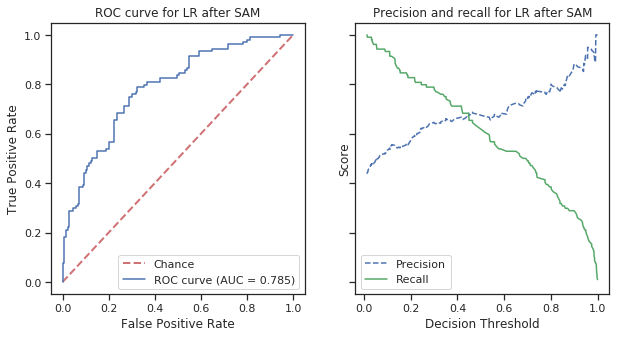

In [22]:
fig, (ax1, ax2) = subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
plot_roc_curve(ax1, models_logit_sam, X_test, y_test, title='ROC curve for LR after SAM') 
y_scores = models_logit_sam.predict_proba(X_test)[:,1]
plot_precision_recall_vs_threshold(ax2, y_test, y_scores, 'LR after SAM', requsted=[0.99, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.5])
show()